# Importation des packages

In [ ]:
# Bibliothèques standard
import random
import re
from google.colab import drive

# Traitement des données et visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from matplotlib_venn import venn3, venn2
from collections import Counter

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Deep Learning avec TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input, Bidirectional, LSTM, GlobalMaxPool1D, Dropout, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import Model, load_model

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Etude jeu de donnée 1
print("Nombre de lignes:", data.shape[0])
print("Nombre de colonnes:", data.shape[1])

# Structure du dataset
print("Structure du dataset:")
print(data.info())

# Statistiques descriptives de base pour chaque colonne
print("Statistiques descriptives:")
print(data.describe())

Nombre de lignes: 159571
Nombre de colonnes: 8
Structure du dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None
Statistiques descriptives:
               toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000   

# Etude du jeu de données

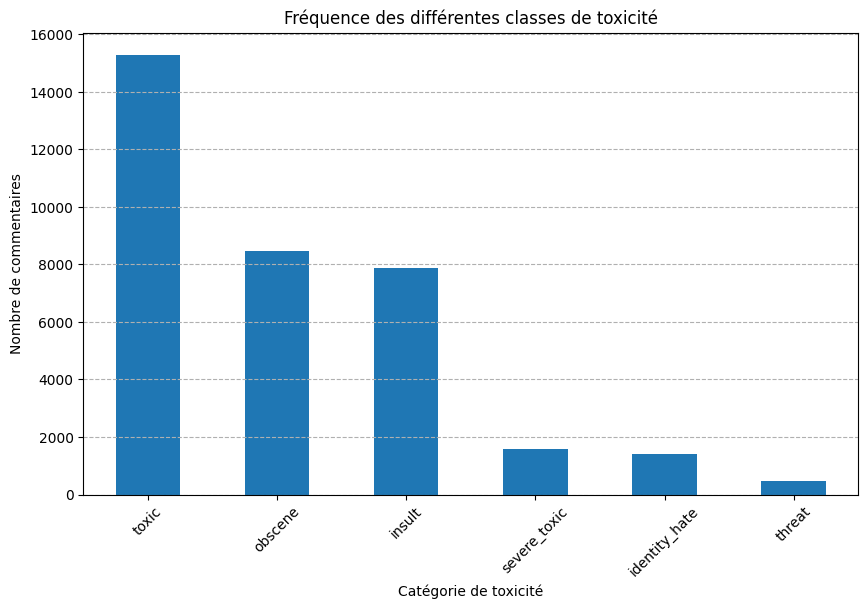

In [ ]:
# Calcul des fréquences pour chaque catégorie de toxicité
frequences_classes = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().sort_values(ascending=False)

# Visualisation via histogramme
plt.figure(figsize=(10, 6))
frequences_classes.plot(kind='bar')
plt.title('Fréquence des différentes classes de toxicité')
plt.xlabel('Catégorie de toxicité')
plt.ylabel('Nombre de commentaires')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

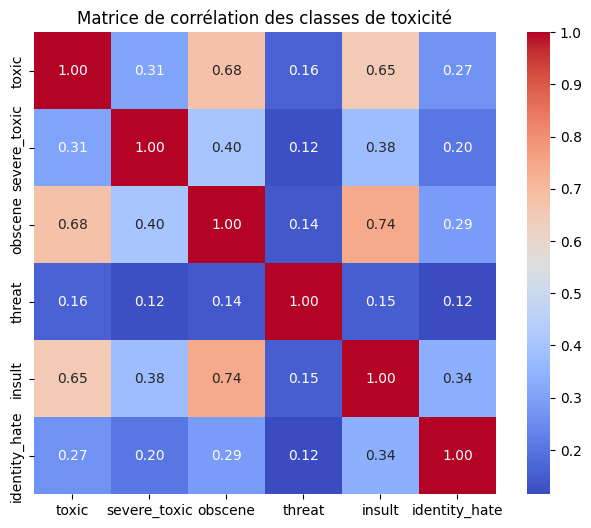

In [ ]:
# Matrice de corrélation
correlation_matrix = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()

# Visualisation matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Matrice de corrélation des classes de toxicité')
plt.show()

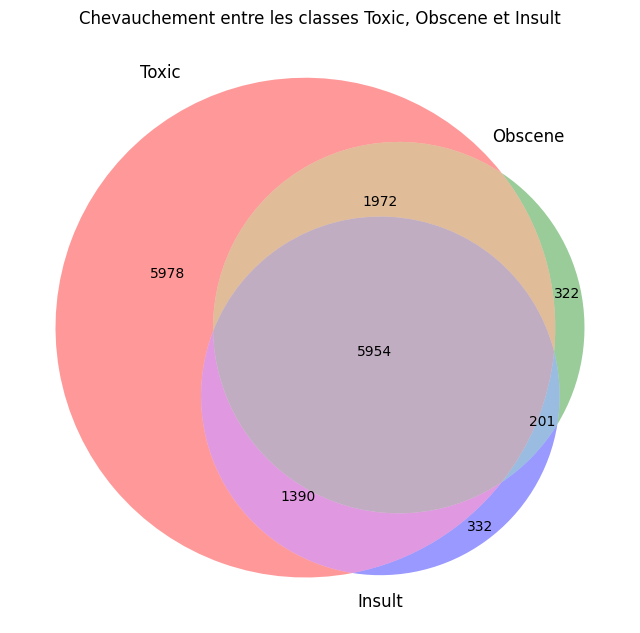

In [ ]:
# Chevauchement entre 'toxic', 'obscene' et 'insult'
set_toxic = set(data[data['toxic'] == 1].index)
set_obscene = set(data[data['obscene'] == 1].index)
set_insult = set(data[data['insult'] == 1].index)

# Diagramme de Venn pour 3 ensembles
plt.figure(figsize=(8, 8))
venn3([set_toxic, set_obscene, set_insult], ('Toxic', 'Obscene', 'Insult'))
plt.title('Chevauchement entre les classes Toxic, Obscene et Insult')
plt.show()

In [ ]:
# Calcul longueur des commentaires
data['comment_length'] = data['comment_text'].apply(len)

# Calcul longueur des commentaires par catégories
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for category in categories:
    mean_length = data.loc[data[category] == 1, 'comment_length'].mean()
    print(f"Longueur moyenne des commentaires pour {category}: {mean_length:.2f}")

Longueur moyenne des commentaires pour toxic: 295.25
Longueur moyenne des commentaires pour severe_toxic: 453.64
Longueur moyenne des commentaires pour obscene: 286.78
Longueur moyenne des commentaires pour threat: 307.74
Longueur moyenne des commentaires pour insult: 277.28
Longueur moyenne des commentaires pour identity_hate: 308.54


In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Initialisation des stopwords
stop_words = set(stopwords.words('english'))

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not",
    "'re": " are", "'s": " is", "'d": " would",
    "'ll": " will", "'t": " not", "'ve": " have",
    "'m": " am", "he's": "he is", "there's": "there is",
    "we're": "we are", "that's": "that is", "they're": "they are",
    "cannot": "cannot", "wasn't": "was not", "don't": "do not",
    "aren't": "are not", "isn't": "is not", "what's": "what is",
    "haven't": "have not", "hasn't": "has not", "there's": "there is",
    "he's": "he is", "it's": "it is", "you're": "you are",
    "shouldn't": "should not", "wouldn't": "would not", "i'm": "I am",
    "isn't": "is not", "here's": "here is", "you've": "you have",
    "we're": "we are", "what's": "what is", "couldn't": "could not",
    "we've": "we have", "it's": "it is", "doesn't": "does not",
    "who's": "who is", "i've": "I have", "y'all": "you all",
    "would've": "would have", "it'll": "it will", "we'll": "we will",
    "weren't": "were not", "they'll": "they will", "they'd": "they would",
    "i'd": "I would", "should've": "should have", "where's": "where is",
    "we'd": "we would", "i'll": "I will", "you'll": "you will",
    "let's": "let us", "ain't": "am not", "you'd": "you would",
}

# Fonction de nettoyage du texte
def clean_text(text):

    # Convertir le texte en minuscules
    text = text.lower()

    # Supprimer les URLs du texte
    text = re.sub(r"http\S+", "", text)

    # Supprimer les mentions dans le texte (tout ce qui commence par '@')
    text = re.sub("(@[A-Za-z0-9_]+)", "", text)

    # Supprimer tous les caractères non alphabétiques et non spatiaux
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # Supprimer les espaces en début et fin de chaîne
    text = text.strip()

    # Remplacer les abréviations/ contractions par leurs formes complètes
    for abbr, full_form in abbreviations.items():
        text = re.sub(r'\b' + re.escape(abbr) + r'\b', full_form, text)
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)

    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# Exemple de test
tweet = "LOL, this is so funny! :D"
cleaned_tweet = clean_text(tweet)
print(cleaned_tweet)

laughing loud funny


In [ ]:
for category in categories:

    # Filtrer les commentaires pour chaque catégorie
    commentaires = data.loc[data[category] == 1, 'comment_text']
    tous_mots = []

    # Nettoyer et extraire les mots de chaque commentaire
    for commentaire in commentaires:
        mots = clean_text(commentaire).split()
        tous_mots.extend(mots)

    # Comptage mots les plus fréquents
    compteur_mots = Counter(tous_mots)
    mots_frequents = compteur_mots.most_common(10)
    print(f"Mots les plus fréquents pour {category}: {mots_frequents}")

Mots les plus fréquents pour toxic: [('fuck', 8724), ('dont', 3558), ('shit', 3485), ('like', 3476), ('nigger', 3289), ('fucking', 3206), ('wikipedia', 3139), ('suck', 2986), ('hate', 2614), ('ass', 2357)]
Mots les plus fréquents pour severe_toxic: [('fuck', 6056), ('suck', 2291), ('shit', 1878), ('faggot', 1570), ('ass', 1476), ('fucking', 1374), ('die', 1020), ('nigger', 1011), ('sucks', 961), ('cunt', 781)]
Mots les plus fréquents pour obscene: [('fuck', 8622), ('fucking', 3105), ('shit', 3100), ('suck', 2773), ('nigger', 2721), ('ass', 2181), ('dont', 1761), ('like', 1528), ('wikipedia', 1513), ('cunt', 1468)]
Mots les plus fréquents pour threat: [('die', 1030), ('kill', 504), ('ass.', 425), ('ass', 345), ('going', 294), ('block', 170), ('must', 166), ('jim', 158), ('wales', 157), ('supertrll', 150)]
Mots les plus fréquents pour insult: [('fuck', 6669), ('nigger', 2774), ('fucking', 2719), ('suck', 2546), ('fat', 1924), ('faggot', 1805), ('dont', 1623), ('shit', 1582), ('ass', 1551

# Préparation des données

In [ ]:
# Chargement des données
train = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
test = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test.csv')

In [ ]:
#stopwords et wordnet
nltk.download('stopwords')
nltk.download('wordnet')

# Gestion des valeurs manquantes
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

# Définition de la fonction de tokenisation
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Suppression des caractères inutiles et mise en minuscule
def tokenize(s):
    s = s.lower()
    s = re.sub('\s+', ' ', s)
    s = re.sub(r'\d+', '', s)

    # Tokenisation
    tokens = re_tok.sub(r' \1 ', s).split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Définition des colonnes de label
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Échantillonnage aléatoire de 30% des données d'entraînement et de test
train_sampled = train.sample(frac=0.3, random_state=42)
test_sampled = test.sample(frac=0.3, random_state=42)

# TF IDF
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, max_df=0.9, strip_accents='unicode',
                      use_idf=1, smooth_idf=1, sublinear_tf=1)

# Création colonne 'is_toxic'
train_sampled['is_toxic'] = train_sampled[label_cols].max(axis=1)

# Vectorisation des commentaires
trn_term_doc = vec.fit_transform(train_sampled['comment_text'])
test_term_doc = vec.transform(test_sampled['comment_text'])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Proportion de commentaires toxiques dans l'ensemble d'entraînement échantillonné : 0.10


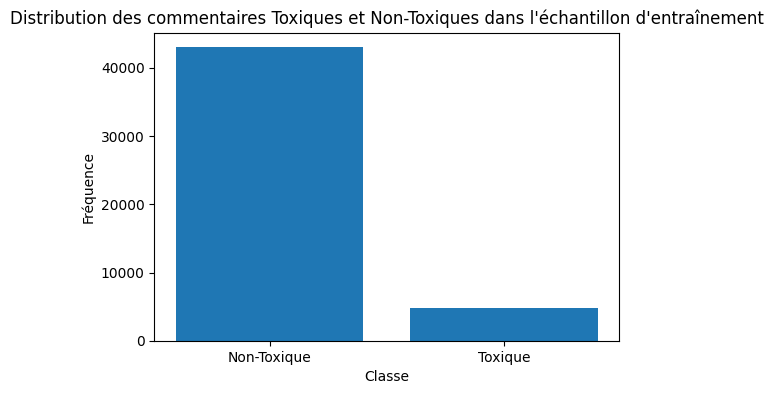

In [ ]:
# Proportion de commentaires toxiques dans l'ensemble d'entraînement échantillonné
proportion_toxic_sampled = train_sampled['is_toxic'].mean()
print(f'Proportion de commentaires toxiques dans l\'ensemble d\'entraînement échantillonné : {proportion_toxic_sampled:.2f}')

# Affichage des distributions
plt.figure(figsize=(6, 4))
plt.hist(train_sampled['is_toxic'], bins=np.arange(-0.5, 2, 1), rwidth=0.8)
plt.title('Distribution des commentaires Toxiques et Non-Toxiques dans l\'échantillon d\'entraînement')
plt.xticks([0, 1], ['Non-Toxique', 'Toxique'])
plt.xlabel('Classe')
plt.ylabel('Fréquence')
plt.show()

# Modèle baseline: RandomForest


In [ ]:
y_train = train_sampled['is_toxic'].values

# Initialisation RandomForest
m = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=18, random_state=21)
m.fit(trn_term_doc, y_train)


preds = m.predict_proba(test_term_doc)[:, 1]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    trn_term_doc,
    train_sampled['is_toxic'].values,
    test_size=0.6,  # 60% des données pour la validation
    random_state=42
)

# Ajustement du modèle
m = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=18, random_state=21)
m.fit(X_train, y_train)

# Prédiction
preds_val = m.predict_proba(X_val)[:, 1]

# Convertir les probabilités avec un seuil de 50%
preds_binary_val = (preds_val > 0.5).astype(int)

# Calcul de l'accuracy sur l'ensemble de validation
accuracy_val = accuracy_score(y_val, preds_binary_val)
print(f'Accuracy sur l\'ensemble de validation: {accuracy_val:.4f}')

Accuracy sur l'ensemble de validation: 0.8990


# Itération de la modélisation

In [ ]:
# Création de la colonne 'is_toxic' pour l'ensemble d'entraînement
train['is_toxic'] = train[label_cols].max(axis=1)

# Préparation des données pour l'échantillonnage stratifié de l'ensemble d'entraînement
X_train = train['comment_text']
y_train = train['is_toxic']

# Échantillonnage stratifié pour créer un ensemble d'entraînement et un ensemble de validation
X_train_sampled, X_val, y_train_sampled, y_val = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

# Vectorisation TF-IDF
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, max_df=0.9, strip_accents='unicode',
                      use_idf=1, smooth_idf=1, sublinear_tf=1)

# Application de TF-IDF sur les échantillons
trn_term_doc = vec.fit_transform(X_train_sampled)
val_term_doc = vec.transform(X_val)

# Entraînement du modèle RandomForest
model = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=18, random_state=21)
model.fit(trn_term_doc, y_train_sampled)

# Évaluation du modèle sur l'ensemble de validation
preds_val = model.predict(val_term_doc)
accuracy_val = accuracy_score(y_val, preds_val)
print(f'Accuracy sur l\'ensemble de validation: {accuracy_val:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy sur l'ensemble de validation: 0.8983


Proportion de commentaires toxiques dans l'ensemble d'entraînement original : 0.10
Proportion de commentaires toxiques dans l'ensemble d'entraînement échantillonné : 0.10


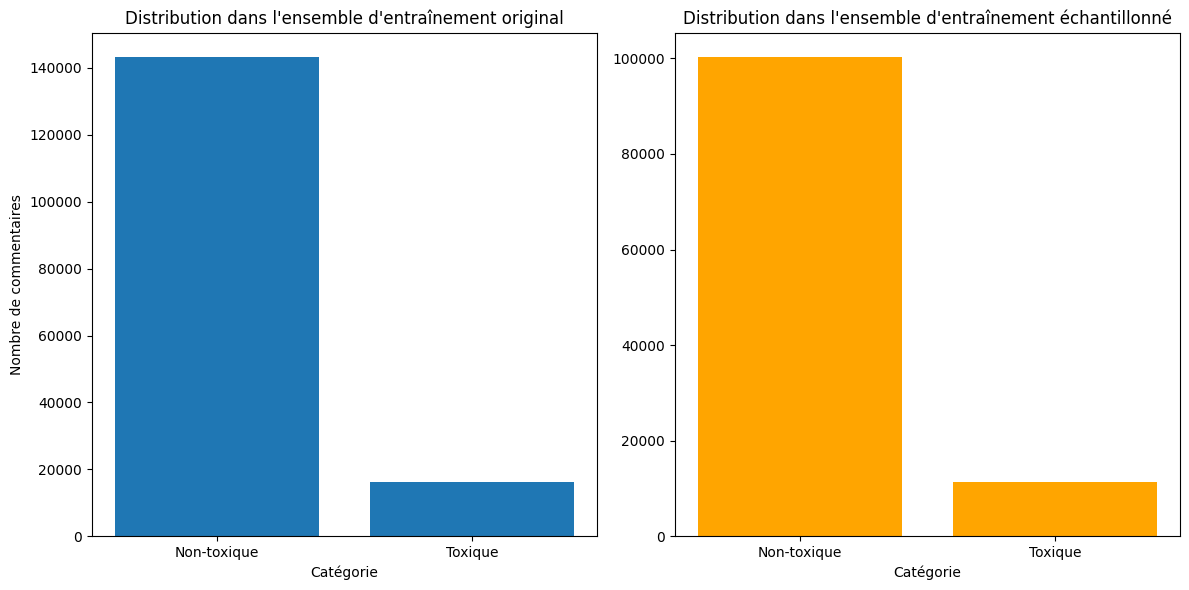

In [ ]:
# Proportion de commentaires toxiques dans l'ensemble d'entraînement original
original_proportion = y_train.mean()
print(f'Proportion de commentaires toxiques dans l\'ensemble d\'entraînement original : {original_proportion:.2f}')

# Proportion de commentaires toxiques dans l'ensemble d'entraînement échantillonné
sampled_proportion = y_train_sampled.mean()
print(f'Proportion de commentaires toxiques dans l\'ensemble d\'entraînement échantillonné : {sampled_proportion:.2f}')

# Affichage des distributions
plt.figure(figsize=(12, 6))

# Distribution dans l'ensemble d'entraînement original
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=np.arange(-0.5, 2, 1), rwidth=0.8)
plt.title('Distribution dans l\'ensemble d\'entraînement original')
plt.xticks([0, 1], ['Non-toxique', 'Toxique'])
plt.xlabel('Catégorie')
plt.ylabel('Nombre de commentaires')

# Distribution dans l'ensemble d'entraînement échantillonné
plt.subplot(1, 2, 2)
plt.hist(y_train_sampled, bins=np.arange(-0.5, 2, 1), rwidth=0.8, color='orange')
plt.title('Distribution dans l\'ensemble d\'entraînement échantillonné')
plt.xticks([0, 1], ['Non-toxique', 'Toxique'])
plt.xlabel('Catégorie')

plt.tight_layout()
plt.show()

# Itération de la modélisation

In [ ]:
# Préparation des données
corpus = list(zip(train_sampled['comment_text'].values, train_sampled['is_toxic'].values))

# Mélange des données pour garantir la randomisation
random.shuffle(corpus)

# Extraction des commentaires et des labels du corpus
sentences = [str(item[0]) for item in corpus]
labels = [item[1] for item in corpus]

# Configuration des paramètres de tokenisation et de séquence
max_length = 100
padding_type = 'post'
trunc_type = 'post'
oov_tok = ""

# Tokenisation
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

# Conversion des textes en séquences et application du padding
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Division des données en ensembles d'entraînement et de test avec stratification
training_sequences, test_sequences, training_labels, test_labels = train_test_split(
    padded, labels, test_size=0.2, stratify=labels, random_state=42)

training_labels = to_categorical(training_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)

In [ ]:
# Configuration des paramètres du modèle
vocab_size = len(tokenizer.word_index) + 1  # Ajout de 1 pour le token OOV
embedding_dim = 100
max_length = 100  # Assurez-vous que cela correspond à la configuration de `pad_sequences`
padding_type = 'post'
trunc_type = 'post'

# Création du modèle
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())  # Aplatit la sortie de l'embedding pour l'alimenter à une couche dense
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraînement du modèle
history = model.fit(training_sequences, np.array(training_labels), epochs=5, validation_data=(test_sequences, np.array(test_labels)))

# Évaluation du modèle
loss, accuracy = model.evaluate(test_sequences, np.array(test_labels))
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9962400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 10602854 (40.45 MB)
Trainable params: 10602854 (40.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1197/1197 [==============================] - 58s 47ms/step - loss: 0.0673 - accuracy: 0.9310 - val_loss: 0.0518 - val_accuracy: 0.9465
E

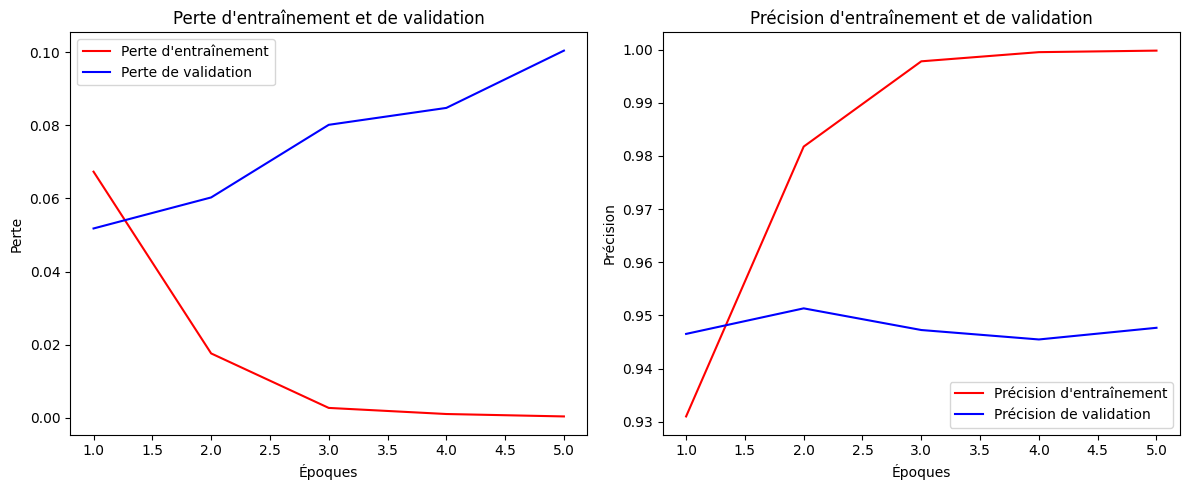

In [ ]:
# Récupération de l'historique de l'entraînement
history_dict = history.history

# Extraction des courbes de perte pour l'entraînement et la validation
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Extraction des courbes de précision pour l'entraînement et la validation
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

# Détermination du nombre d'époques
epochs = range(1, len(loss_values) + 1)

# Tracé de la courbe de perte
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'r', label='Perte d\'entraînement')
plt.plot(epochs, val_loss_values, 'b', label='Perte de validation')
plt.title('Perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Tracé de la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'r', label='Précision d\'entraînement')
plt.plot(epochs, val_accuracy_values, 'b', label='Précision de validation')
plt.title('Précision d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()


# Itération de la modélisation

In [ ]:
# Configuration des paramètres du modèle
vocab_size = len(tokenizer.word_index) + 1  # Ajout de 1 pour le token OOV
embedding_dim = 100
max_length = 100  # Assurez-vous que cela correspond à la configuration de `pad_sequences`
padding_type = 'post'
trunc_type = 'post'

# Création du modèle
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SimpleRNN(64))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraînement du modèle
history = model.fit(training_sequences, np.array(training_labels), epochs=5, validation_data=(test_sequences, np.array(test_labels)))

# Évaluation du modèle
loss, accuracy = model.evaluate(test_sequences, np.array(test_labels))
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9962400   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
Total params: 10023270 (38.24 MB)
Trainable params: 10023270 (38.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
11

# Itération de la modélisation

In [ ]:
# Construction du modèle
max_features = len(word_index) + 1  # La taille du vocabulaire est basée sur les données d'entraînement des commentaires
embed_size = 100  # Taille de l'embedding que vous avez utilisée dans votre code précédent

inp = Input(shape=(max_length,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
out = Dense(6, activation="sigmoid")(x)  # 6 classes pour les labels toxiques
model = Model(inputs=inp, outputs=out)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.fit(training_sequences, training_labels, batch_size=32, epochs=2, validation_split=0.1)

Epoch 1/2
1078/1078 [==============================] - 724s 664ms/step - loss: 0.0840 - accuracy: 0.9250 - val_loss: 0.0392 - val_accuracy: 0.9611
Epoch 2/2
1078/1078 [==============================] - 707s 656ms/step - loss: 0.0307 - accuracy: 0.9683 - val_loss: 0.0385 - val_accuracy: 0.9564


Séquence de tokens : [  698     8    19    55   282    60   122    16     2 23484  1444  6968
  1127    29    12    48   738    10     7    19   857    60     4    30
   904  3523    22    31 90833   259    13   366    53   703   102    56
    48    19    55   206  5584     3     6   565  1202    40    25    21
   210    13   282    14     5    71    41     8   945    12     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Labels associés : [1. 0. 0. 0. 0. 0.]
-----
Séquence de tokens : [   45  1076     5    15 26306    64    47  8396   232    48   153    35
    40     7    34   297     5  1444   297   151   297   737   151   737
  1115   151  1115   427   151   427     5    15  4812    10     7   119
     6  2682  3736     8    19     3    67     7    20     6   103  6941
  6144   232

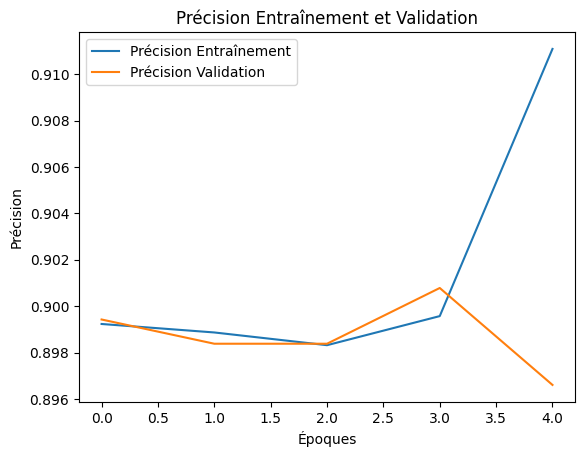

In [ ]:
# Afficher les premières 5 séquences d'entraînement et leurs labels
for i in range(5):
    print("Séquence de tokens :", training_sequences[i])
    print("Labels associés :", training_labels[i])
    print("-----")
  # Inverser le mapping token -> mot
index_word = {v: k for k, v in tokenizer.word_index.items()}

# Fonction pour décoder une séquence
def decode_sequence(sequence):
    return ' '.join([index_word.get(token, '?') for token in sequence])

# Décoder et afficher une séquence d'entraînement
print("Séquence originale :", training_sequences[0])
print("Séquence décodée :", decode_sequence(training_sequences[0]))

model.summary()

plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision Validation')
plt.title('Précision Entraînement et Validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

In [ ]:
def classer_commentaire(commentaire):
    commentaire_nettoye = clean_text(commentaire)

    # Transformation du commentaire en séquence
    sequence = tokenizer.texts_to_sequences([commentaire_nettoye])

    # Application du padding pour atteindre la longueur souhaitée
    padded_sequence = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')

    # Prédiction avec le modèle
    prediction = model.predict(padded_sequence)

    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    return {label: pred for label, pred in zip(labels, prediction.flatten())}

# Exemple d'utilisation
commentaire = "You, sir, are my hero"
predictions = classer_commentaire(commentaire)
print("Prédictions des labels de toxicité :", predictions)

1/1 [==============================] - 0s 211ms/step
Prédictions des labels de toxicité : {'toxic': 0.9871811, 'severe_toxic': 0.013503185, 'obscene': 3.5525372e-05, 'threat': 0.00010574169, 'insult': 3.6986774e-05, 'identity_hate': 6.624656e-05}
